## Global Sensitivity Analysis

To understand how the uncertainties influence the outcomes of the model this notebook performs a global sensitivity analysis using the Sobol method using the EMA workbench (SaLib). 

-------------------------
#### 0. Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (
    Samplers,
    Policy,
    ema_logging,
    SequentialEvaluator,
    save_results
)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from SALib.analyze import sobol


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


----------------
### 1. SaLib

In [3]:
# Turn on logging
ema_logging.log_to_stderr(ema_logging.INFO)

# Policy formulation number 2 is chosen, as this is in line with the intrest of our client the Delta Commision
dike_model, planning_steps = get_model_for_problem_formulation(6)

In [4]:
# Define the model uncertainties
import copy
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [5]:
# Define the model levers
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [6]:
# Printing the model outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x11d934040>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x11d934040>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x11d934040>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x11d934040>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function=<function sum_over at 0x11d

In [7]:
# Define a dictionary with all levers set to zero
lever_settings = {lever.name: 0 for lever in levers}

# Define the policy with all levers set to zero (no release)
zero_policy = Policy("Zero Policy", **lever_settings)

In [8]:
n_exp = 1000 # Number of experiments

In [13]:
# Perform experiments with Sobol sampling, using the zero-policy
# Setting up 40000 scenarios to match M=1000 with 19 uncertainties (2k+2)M = 40*1000 = 40000
with SequentialEvaluator(dike_model) as evaluator:
    experiments, results = evaluator.perform_experiments(scenarios=n_exp, policies=[zero_policy],
                                                         uncertainty_sampling=Samplers.SOBOL)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 400 scenarios * 1 policies * 1 model(s) = 400 experiments
  0%|                                                  | 0/400 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially


100%|████████████████████████████████████████| 400/400 [09:48<00:00,  1.47s/it]
[MainProcess/INFO] experiments finished


In [14]:
# Save the results
save_results((experiments, results), 'sequential_results.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/catomartens/Desktop/EPA141 MODEL BASED/epa141A_open-master/final assignment/sequential_results.tar.gz


In [15]:
# Print the experiments
problem = get_SALib_problem(uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


---------
### 2. Visual Analysis

In [16]:
# Analyze using Sobol for Expected Annual Damage
Si_damage = sobol.analyze(problem, results['Expected Annual Damage'], calc_second_order=True, print_to_console=True)
# Analyze using Sobol for Dike Investment Costs
Si_dike_investment = sobol.analyze(problem, results['Dike Investment Costs'], calc_second_order=True, print_to_console=True)
# Analyze using Sobol for RfR Investment Costs
Si_rfr_investment = sobol.analyze(problem, results['RfR Investment Costs'], calc_second_order=True, print_to_console=True)
# Analyze using Sobol for Evacuation Costs
Si_evacuation_costs = sobol.analyze(problem, results['Evacuation Costs'], calc_second_order=True, print_to_console=True)
# Analyze using Sobol for Expected Number of Deaths
Si_deaths = sobol.analyze(problem, results['Expected Number of Deaths'], calc_second_order=True, print_to_console=True)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.020565  0.056969
A.1_Bmax                 0.000332  0.000822
A.1_Brate                0.000002  0.000005
A.1_pfail                0.476415  0.937569
A.2_Bmax                 0.000007  0.000020
A.2_Brate                0.000000  0.000000
A.2_pfail                0.029776  0.067568
A.3_Bmax                 0.000000  0.000000
A.3_Brate                0.000000  0.000000
A.3_pfail                0.256592  0.507144
A.4_Bmax                 0.000000  0.000000
A.4_Brate                0.000000  0.000000
A.4_pfail                0.000982  0.002231
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.005089  0.010883
discount rate 0          0.022360  0.029109
discount rate 1          0.045396  0.113533
discount rate 2          0.013529  0.024354
                               S1   S1_conf
A.0_ID flood wave shape -0.053735  0.129460
A.1_Bmax                 0.00683

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/analyze/sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/analyze/sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/analyze/sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.011626  0.034449
A.1_Bmax                 0.000268  0.000717
A.1_Brate                0.000001  0.000005
A.1_pfail                0.126429  0.173810
A.2_Bmax                 0.000019  0.000057
A.2_Brate                0.000000  0.000000
A.2_pfail                0.011786  0.019064
A.3_Bmax                 0.000000  0.000000
A.3_Brate                0.000000  0.000000
A.3_pfail                0.677484  0.526182
A.4_Bmax                 0.000000  0.000000
A.4_Brate                0.000000  0.000000
A.4_pfail                0.000135  0.000331
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.002990  0.008028
discount rate 0          0.000000  0.000000
discount rate 1          0.000000  0.000000
discount rate 2          0.000000  0.000000
                               S1   S1_conf
A.0_ID flood wave shape -0.012680  0.074419
A.1_Bmax                 0.00090

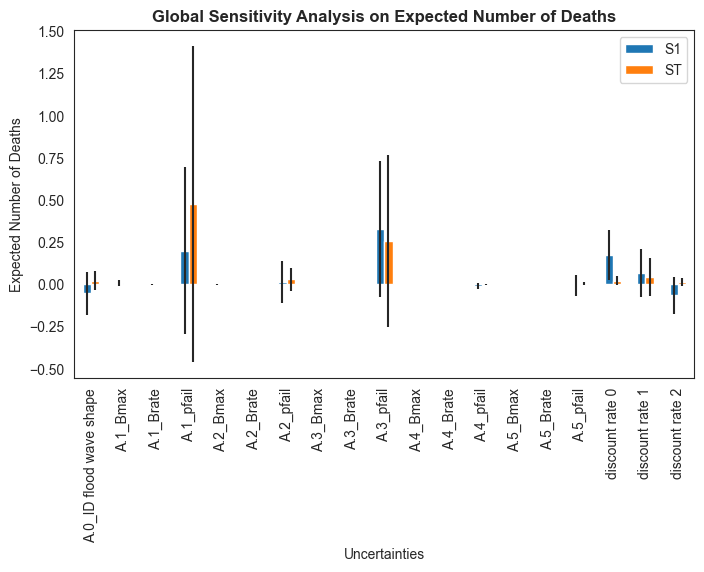

In [17]:
# Plot the results for Expected Annual Damage
Si_filter = {k:Si_damage[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.title('Global Sensitivity Analysis on Expected Number of Deaths',fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Expected Number of Deaths')
plt.show()

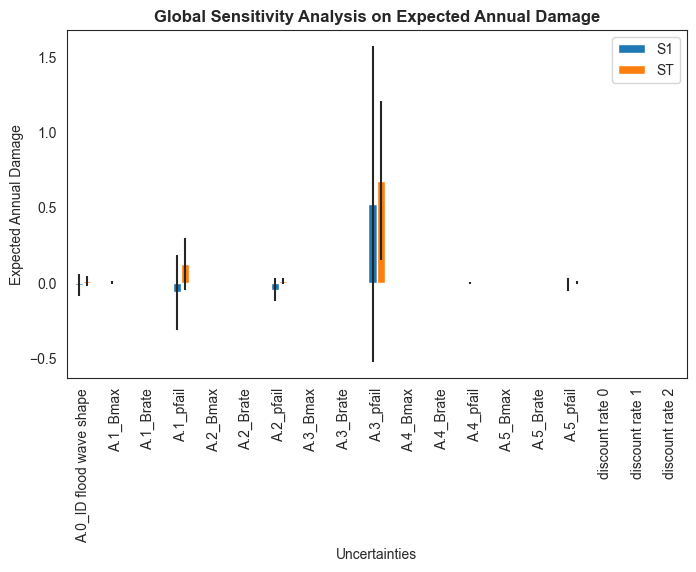

In [18]:
# Plot the results for Expected Number of Deaths
Si_filter = {k:Si_deaths[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.title('Global Sensitivity Analysis on Expected Annual Damage',fontweight='bold')
plt.xlabel('Uncertainties')
plt.ylabel('Expected Annual Damage')
plt.show()


--------
### 3. Results

#### Sobol Analysis on Expected Annual Damage
**Key Uncertainties:**
- A3_3_pfail (Probability of Failure for Dike Ring 3): This uncertainty has the highest sensitivity indices (both first-order and total), indicating it has the most significant impact on expected annual damage.
- A1_pfail (Probability of Failure for Dike Ring 1): This variable also shows considerable influence, reflecting its importance in the model.

#### Sobol Analysis on Expected Number of Deaths
**Key Uncertainties:**
- A1_pfail (Probability of Failure for Dike Ring 1): This uncertainty shows the highest sensitivity indices, making it the most significant factor affecting the expected number of deaths.
- A3_3_pfail (Probability of Failure for Dike Ring 3): This also plays a critical role, although its influence is slightly less compared to A1_pfail.
- Other Factors: Variables like Discount Rate, A2_Bmax (Breach Width for Dike Ring 2) and A3_Brate (Breach Growth Rate for Dike Ring 3) also impact the expected number of deaths but to a lesser degree.